In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dask.distributed import Client
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from common.preprocessing import CropDataProcessor

import time

import pickle

In [3]:
client = Client(processes=False)

In [4]:
train_data = pd.read_csv("../data/Crop_Data__train.csv")

In [5]:
train_data.shape

(164986, 25)

In [6]:
data_preprocessor = CropDataProcessor(train_data, excluded_features=['Dew_Frost_Point', 'Year'])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
data_preprocessor.get_training_data()[0].shape

Warning 1: Features are not processed yet.
Warning 2: Distribution of Yield may not be normal.


(164986, 21)

In [8]:
data_preprocessor.process_to_train()

Clustered Lat-Long to Geo Region.
Encoded Crop using WoE.
Transforming numerical features.
Transforming categorical features.


In [9]:
X, y = data_preprocessor.get_training_data()
X.shape, y.shape

((164986, 28), (164986,))

In [10]:
# print(data_preprocessor.process_to_predict(train_data.loc[100:105].drop(['Area', 'Production'], axis=1)).shape)
# data_preprocessor.process_to_predict(train_data.loc[100:105].drop(['Area', 'Production'], axis=1))[:10]

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

In [58]:
X_train.shape, X_val.shape

((131988, 28), (32998, 28))

In [16]:
start_time = time.time()

reg = RandomForestRegressor(n_estimators=40,
                            min_samples_split=2,
                            min_samples_leaf=2,
                            n_jobs=-1,
                            random_state=101)

with joblib.parallel_backend('dask'):
    reg.fit(X_train, y_train)
    
print(f"Finished in {time.time() - start_time} secs")

Finished in 10.303147792816162 secs


In [17]:
reg.score(X_train, y_train)

0.9735075151688256

In [18]:
reg.score(X_val, y_val)

0.8960729257744161

# Hyper-parameters search for RF

## RandomizedSearchCV

### Iter 1

In [13]:
param_space = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": [25, 50, 75, 100],
    "min_samples_split": np.arange(2, 15, 2),
    "min_samples_leaf": np.arange(2, 11, 2)
}

In [16]:
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(), 
    param_distributions=param_space,
    cv=5,
    return_train_score=True,
    n_iter=100,
    n_jobs=-1,
    verbose=5)

In [17]:
with joblib.parallel_backend('dask'):
    random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 4/5] END max_depth=100, min_samples_leaf=2, min_samples_split=14, n_estimators=30; total time= 1.4min
[CV 2/5] END max_depth=100, min_samples_leaf=2, min_samples_split=14, n_estimators=30; total time= 1.4min
[CV 1/5] END max_depth=100, min_samples_leaf=2, min_samples_split=14, n_estimators=30; total time= 1.5min
[CV 5/5] END max_depth=50, min_samples_leaf=8, min_samples_split=14, n_estimators=40; total time= 1.5min
[CV 4/5] END max_depth=50, min_samples_leaf=8, min_samples_split=14, n_estimators=40; total time= 1.6min
[CV 3/5] END max_depth=100, min_samples_leaf=2, min_samples_split=14, n_estimators=30; total time= 1.7min
[CV 3/5] END max_depth=50, min_samples_leaf=8, min_samples_split=14, n_estimators=40; total time= 1.7min
[CV 2/5] END max_depth=50, min_samples_leaf=8, min_samples_split=14, n_estimators=40; total time= 1.8min
[CV 3/5] END max_depth=25, min_samples_leaf=8, min_samples_split=10, n_estimators=30; total t

In [21]:
# with open('random_search_1', 'wb') as f:
#     pickle.dump(random_search, f)

with open('random_search_1', 'rb') as f:
    random_search = pickle.load(f)

In [22]:
random_search.best_params_

{'n_estimators': 90,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 100}

In [23]:
random_search.best_score_

0.8973704356487197

Text(0, 0.5, 'Test Score')

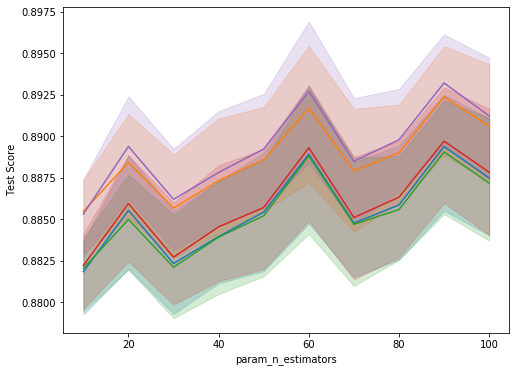

In [25]:
rs_cv_results_1 = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=rs_cv_results_1)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

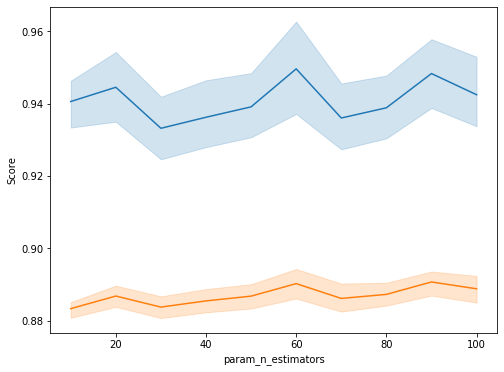

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

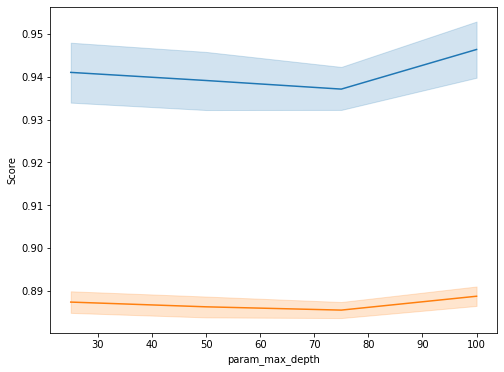

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

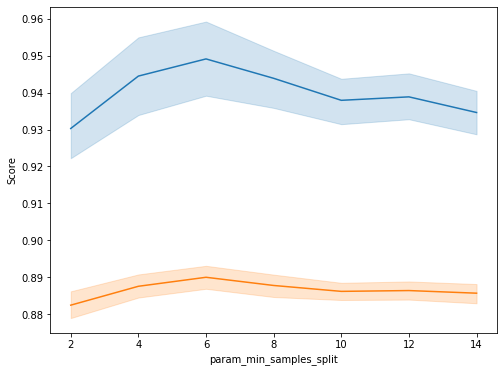

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_min_samples_split', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

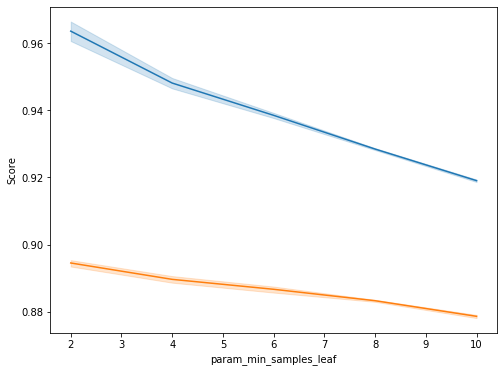

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_min_samples_leaf', y='mean_train_score', data=rs_cv_results_1)
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_cv_results_1)
plt.ylabel('Score')

In [17]:
rs_cv_results_1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_depth', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

### Iter 2

In [12]:
param_space_2 = {
    "n_estimators": np.arange(80, 201, 20),
    "max_depth": np.arange(80, 151, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

random_search_2 = RandomizedSearchCV(
    estimator=RandomForestRegressor(), 
    param_distributions=param_space_2,
    cv=5, 
    return_train_score=True,
    n_iter=25,
    verbose=5,
    n_jobs=-1
)

# with joblib.parallel_backend('dask'):
random_search_2.fit(X, y)

# with open('random_search_2', 'wb') as f:
#     pickle.dump(random_search_2, f)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [13]:
with open('random_search_2', 'rb') as f:
    random_search_2 = pickle.load(f)

In [14]:
random_search_2.best_params_

{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 90}

In [15]:
random_search_2.best_score_

0.8981652197447803

In [31]:
pd.DataFrame(random_search_2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,228.923209,1.842021,1.769463,0.089703,80,4,2,150,"{'n_estimators': 80, 'min_samples_split': 4, '...",0.895888,...,0.897371,0.001668,23,0.974331,0.974624,0.974701,0.974335,0.974281,0.974454,0.000173
1,283.678664,0.857808,2.270099,0.027870,100,4,2,90,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.895852,...,0.897546,0.001576,21,0.974604,0.974486,0.974671,0.974415,0.974386,0.974512,0.000109
2,286.918101,1.217938,2.270778,0.042794,100,4,2,80,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.895650,...,0.897504,0.001766,22,0.974648,0.974687,0.974718,0.974538,0.974369,0.974592,0.000127
3,571.312161,2.651847,4.377729,0.104672,200,4,2,80,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.896548,...,0.898019,0.001714,8,0.974949,0.974897,0.975148,0.974808,0.974826,0.974926,0.000122
4,458.159763,3.033906,3.681257,0.137287,160,4,2,150,"{'n_estimators': 160, 'min_samples_split': 4, ...",0.896637,...,0.898103,0.001682,4,0.974755,0.974829,0.974958,0.974749,0.974748,0.974808,0.000081
5,575.827561,3.090686,4.578580,0.242832,200,4,2,140,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.896304,...,0.897854,0.001646,13,0.974831,0.974816,0.975063,0.974759,0.974735,0.974841,0.000117
6,231.470660,2.411722,1.849996,0.135591,80,4,2,110,"{'n_estimators': 80, 'min_samples_split': 4, '...",0.895765,...,0.897194,0.001863,25,0.974525,0.974381,0.974664,0.974193,0.974230,0.974398,0.000177
7,401.869664,1.522608,3.232876,0.107458,140,4,2,150,"{'n_estimators': 140, 'min_samples_split': 4, ...",0.896669,...,0.898003,0.001693,9,0.974769,0.974800,0.975024,0.974592,0.974629,0.974763,0.000153
8,574.451271,4.520756,4.443873,0.176273,200,4,2,100,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.896296,...,0.898131,0.001804,3,0.974871,0.974960,0.975017,0.974742,0.974707,0.974859,0.000120
9,571.780703,1.425852,4.445948,0.173451,200,4,2,130,"{'n_estimators': 200, 'min_samples_split': 4, ...",0.896944,...,0.898059,0.001586,7,0.974937,0.974914,0.975098,0.974790,0.974804,0.974909,0.000111


Text(0, 0.5, 'Test Score')

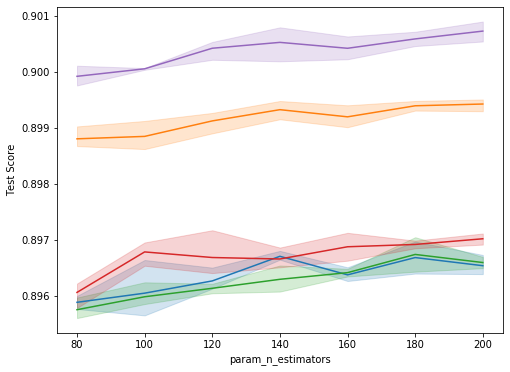

In [26]:
rs_cv_results_2 = pd.DataFrame(random_search_2.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=rs_cv_results_2)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

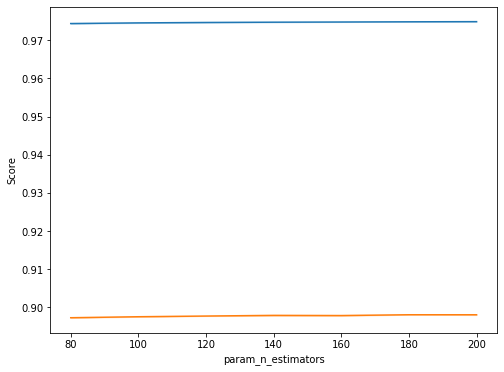

In [27]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=rs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

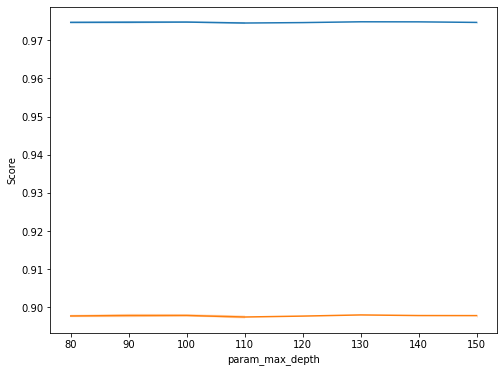

In [28]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=rs_cv_results_2)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

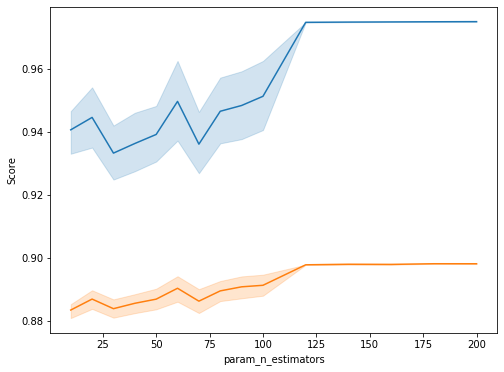

In [29]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
plt.ylabel('Score')

Text(0, 0.5, 'Score')

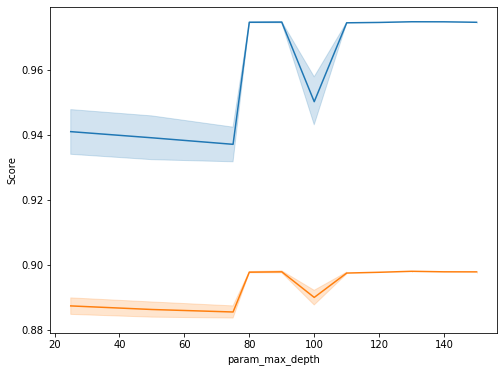

In [30]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.concat([rs_cv_results_1, rs_cv_results_2]))
plt.ylabel('Score')

## GridSearchCV

### Iter 1

In [33]:
grid_param = {
    "n_estimators": np.arange(100, 151, 10),
    "max_depth": np.arange(80, 121, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=101),
    param_grid=grid_param,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=10)

# with joblib.parallel_backend('dask'):
grid_search.fit(X, y)

# with open('grid_search_1', 'wb') as f:
#     pickle.dump(grid_search, f)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [34]:
with open('grid_search_1', 'rb') as f:
    grid_search = pickle.load(f)

In [35]:
grid_search.best_params_

{'max_depth': 80,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

In [36]:
grid_search.best_score_

0.8979205987281571

Text(0, 0.5, 'Test Score')

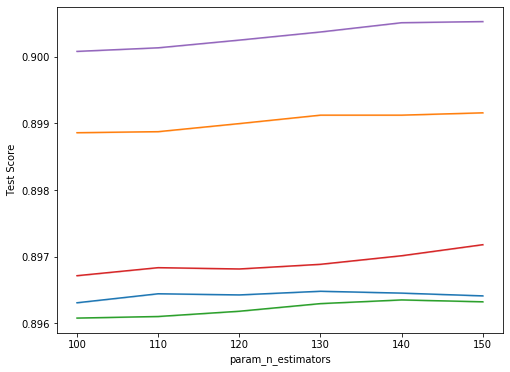

In [37]:
gs_cv_results_1 = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=gs_cv_results_1)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

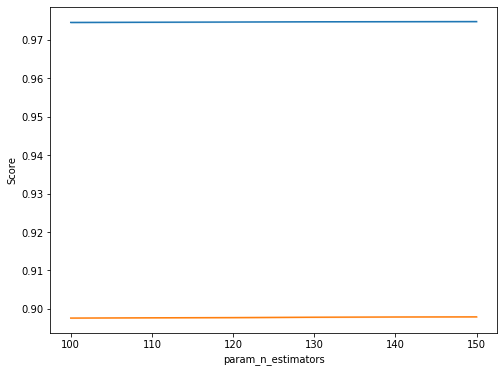

In [38]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=gs_cv_results_1)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_cv_results_1)
plt.ylabel('Score')

In [41]:
gs_cv_results_1.mean_train_score.std()

8.146219030687776e-05

In [42]:
gs_cv_results_1.mean_test_score.std()

0.00011480598141133165

Text(0, 0.5, 'Score')

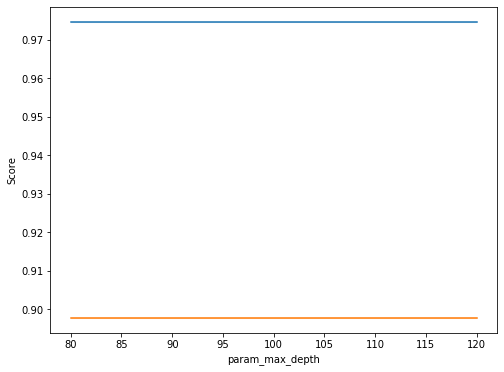

In [39]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=gs_cv_results_1)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=gs_cv_results_1)
plt.ylabel('Score')

### Iter 2

In [44]:
grid_param_2 = {
    "n_estimators": np.arange(10, 101, 10),
    "max_depth": np.arange(10, 81, 10),
    "min_samples_split": [4],
    "min_samples_leaf": [2]
}

grid_search_2 = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=101),
    param_grid=grid_param_2,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=10)

# with joblib.parallel_backend('dask'):
grid_search_2.fit(X, y)

# with open('grid_search_2', 'wb') as f:
#     pickle.dump(grid_search_2, f)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [45]:
with open('grid_search_2', 'rb') as f:
    grid_search_2 = pickle.load(f)

In [46]:
grid_search_2.best_params_

{'max_depth': 60,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [47]:
grid_search_2.best_score_

0.8976087631757877

Text(0, 0.5, 'Test Score')

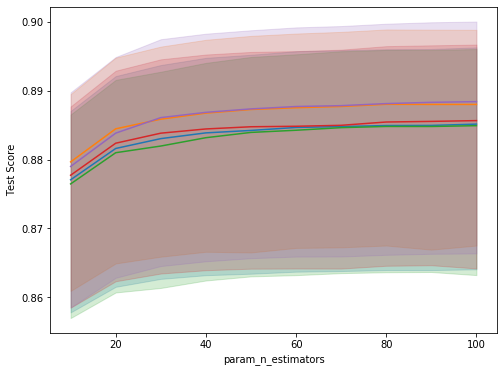

In [49]:
gs_cv_results_2 = pd.DataFrame(grid_search_2.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='split0_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split1_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split2_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split3_test_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='split4_test_score', data=gs_cv_results_2)
plt.ylabel('Test Score')

Text(0, 0.5, 'Score')

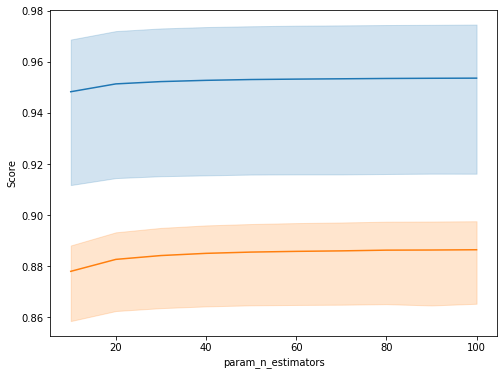

In [50]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=gs_cv_results_2)
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

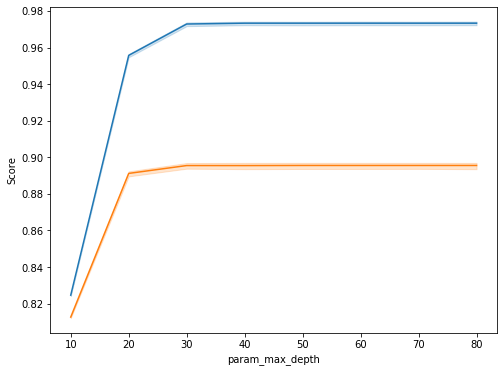

In [51]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=gs_cv_results_2)
sns.lineplot(x='param_max_depth', y='mean_test_score', data=gs_cv_results_2)
plt.ylabel('Score')

Text(0, 0.5, 'Score')

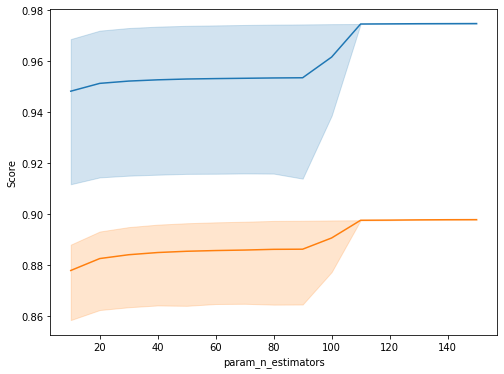

In [53]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_n_estimators', y='mean_train_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
plt.ylabel('Score')

Text(0, 0.5, 'Score')

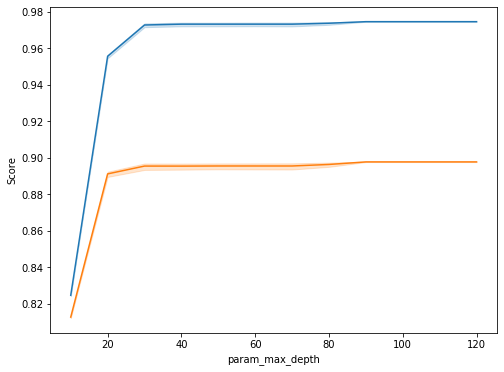

In [54]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='param_max_depth', y='mean_train_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
sns.lineplot(x='param_max_depth', y='mean_test_score', data=pd.concat([gs_cv_results_2, gs_cv_results_1]))
plt.ylabel('Score')

# Model based on hyper-parameters search

Based on above results we get following as best possible hyperparameters for RandomForestRegressor:

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 110}

In [70]:
reg = RandomForestRegressor(n_estimators=110,
                            max_depth=20,
                            min_samples_leaf=2,
                            min_samples_split=4,
                            n_jobs=-1,
                            random_state=101)

In [71]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=110, n_jobs=-1, random_state=101)

In [72]:
print("Training score: ", reg.score(X_train, y_train))

Training score:  0.9564203121700371


In [73]:
print("Test score: ", reg.score(X_val, y_val))

Test score:  0.8929335064120425
